# Torob Project: Product Category Classification Based On Images

## ⭕ Install dependencies


In [1]:
!pip install -q -U datasets gdown transformers

In [2]:
import random

from datasets import load_dataset
from transformers import AutoImageProcessor, ResNetModel
import torch
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np

## ⭕ Download Data


In [3]:
!gdown 1DM8cKZFFU1z5fN7h34l3Ji6h5UytYMpb

Downloading...
From (uriginal): https://drive.google.com/uc?id=1DM8cKZFFU1z5fN7h34l3Ji6h5UytYMpb
From (redirected): https://drive.google.com/uc?id=1DM8cKZFFU1z5fN7h34l3Ji6h5UytYMpb&confirm=t&uuid=5d032cb9-899b-4a08-b6a2-5aa23dcd19f5
To: /content/torob-product-images.zip
100% 445M/445M [00:02<00:00, 192MB/s]


## ⭕ Load Data


In [4]:
dataset = load_dataset("imagefolder", data_files="./torob-product-images.zip", split='train')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-2414954df0e51951/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


In [5]:
dataset.features['label'].names

['fryer',
 'graphic-card',
 'mens-boots',
 'mens-sandals',
 'mens-sport-shoes',
 'microwave',
 'mobile',
 'motherboard',
 'tablet',
 'toaster']

Label of following image: mens-sport-shoes


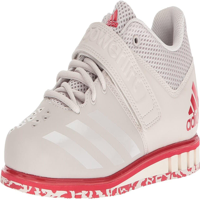

Label of following image: mens-boots


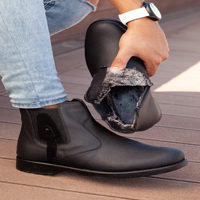

Label of following image: mens-boots


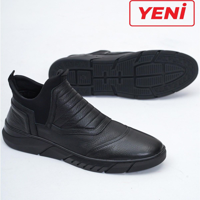

Label of following image: mens-sandals


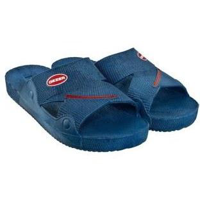

Label of following image: mobile


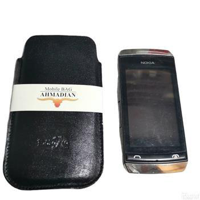

Label of following image: microwave


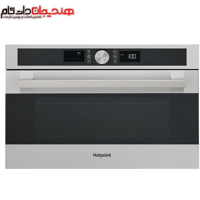

Label of following image: tablet


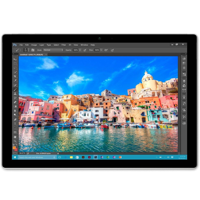

Label of following image: mens-boots


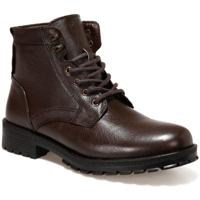

Label of following image: motherboard


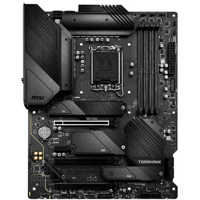

Label of following image: mens-sandals


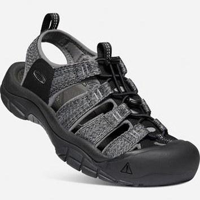

In [6]:
sampled_idx = random.sample(range(len(dataset)), k=10)
sampled_data = dataset.select(sampled_idx)

for img, lbl in zip(sampled_data["image"], sampled_data["label"]):
  print("Label of following image:", dataset.features['label'].names[lbl])
  display(img.resize((200, 200)))
  print("="*80)

## ⭕ Train-Test Split


In [7]:
splited_dataset = dataset.train_test_split(test_size=0.2, stratify_by_column='label', shuffle=True, seed=42)
train_dataset = splited_dataset["train"]
test_dataset = splited_dataset["test"]

## ⭕ Simple Features Extraction

In [8]:
def calculate_simple_features(example):
  img_mean = np.mean(example["image"], axis=(0, 1))
  img_std = np.std(example["image"], axis=(0, 1))
  example["simple_features"] = np.concatenate((img_mean, img_std), axis=-1)
  return example

In [9]:
train_dataset = train_dataset.map(calculate_simple_features)
test_dataset = test_dataset.map(calculate_simple_features)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [10]:
assert len(train_dataset["simple_features"][0]) == 6
assert len(test_dataset["simple_features"][0]) == 6
print("Well done!")

Well done!


In [11]:
# Defining X_train, X_test, y_train, y_test

X_train = train_dataset['simple_features']
X_test = test_dataset['simple_features']
y_train = train_dataset['label']
y_test = test_dataset['label']

## ⭕ Train and Evaluate Models on Simple Features

### 🔵 KNN Classifier

In [12]:
# Finding best hyperparameters of knn by using GridSearchCV

from sklearn.model_selection import GridSearchCV

parameters = dict(n_neighbors=[3, 5, 9, 11, 13])

knn_classifier = KNeighborsClassifier()

grid = GridSearchCV(knn_classifier, param_grid=parameters ,cv=10, scoring='accuracy', n_jobs=-1, verbose=10)

grid.fit(X_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 9, 11, 13]}, scoring='accuracy',
             verbose=10)

In [13]:
# The best k for knn
grid.best_params_

{'n_neighbors': 13}

In [14]:
knn_classifier = KNeighborsClassifier(n_neighbors=13)

knn_classifier.fit(X_train, y_train)

knn_classifier.score(X_test, y_test)

0.3345

### 🔵 Decision Tree Classifier

In [15]:
# Finding best hyperparameters of DTC by using GridSearchCV

parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

dt_classifier = DecisionTreeClassifier()

grid = GridSearchCV(dt_classifier, param_grid=parameters ,cv=3, scoring='accuracy', n_jobs=-1, verbose=10)

grid.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 20],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy', verbose=10)

In [16]:
# The best hyper parameters for DTC
grid.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 10}

In [17]:
dt_classifier = DecisionTreeClassifier(
    criterion = 'gini',
    max_depth = 10,
    max_features = None,
    min_samples_leaf =  4,
    min_samples_split = 2
)

dt_classifier.fit(X_train, y_train)

dt_classifier.score(X_test, y_test)

0.309

### 🔵 Random Forest Classifier

In [18]:
# Finding best hyperparameters of RFC using GridSearchCV

parameters = {
    "n_estimators": [100, 200, 500],
    "max_depth": [5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ['sqrt', 'log2']
}

rf_classifier = RandomForestClassifier()

grid = GridSearchCV(rf_classifier, param_grid=parameters ,cv=3, scoring='accuracy', n_jobs=-1, verbose=10)

grid.fit(X_train, y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             scoring='accuracy', verbose=10)

In [19]:
# The best hyper parameters for RFC
grid.best_params_

{'max_depth': 20,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 200}

In [20]:
rf_classifier = RandomForestClassifier(
    n_estimators = 100,
    max_depth = 20,
    min_samples_split = 2,
    min_samples_leaf = 2,
    max_features = 'sqrt'
)

rf_classifier.fit(X_train, y_train)

rf_classifier.score(X_test, y_test)

0.3795

## ⭕ Histogram Features Extraction

In [21]:
def calculate_histogram_features(example, n_bins=16):
  img_hist, _ = np.histogram(example["image"], bins=n_bins, range=(0, 255))
  # We normalize the histogram values so it would be independent of the size of image.
  img_hist = img_hist / img_hist.sum()
  example["histogram_features"] = img_hist
  return example

In [22]:
train_dataset = train_dataset.map(calculate_histogram_features)
test_dataset = test_dataset.map(calculate_histogram_features)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [23]:
assert len(train_dataset["histogram_features"][0]) == 16
assert len(test_dataset["histogram_features"][0]) == 16
print("Well done!")

Well done!


In [24]:
# Defining X_train, X_test, y_train, y_test

X_train = train_dataset['histogram_features']
X_test = test_dataset['histogram_features']
y_train = train_dataset['label']
y_test = test_dataset['label']

## ⭕ Train and Evaluate Models on Histogram Features

### 🔵 KNN Classifier

In [25]:
# Finding best hyperparameters of knn by using GridSearchCV

from sklearn.model_selection import GridSearchCV

parameters = dict(n_neighbors=[3, 5, 9, 11, 13])

knn_classifier = KNeighborsClassifier()

grid = GridSearchCV(knn_classifier, param_grid=parameters ,cv=10, scoring='accuracy', n_jobs=-1, verbose=10)

grid.fit(X_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 9, 11, 13]}, scoring='accuracy',
             verbose=10)

In [26]:
# The best k for knn
grid.best_params_

{'n_neighbors': 13}

In [27]:
knn_classifier = KNeighborsClassifier(n_neighbors=13)

knn_classifier.fit(X_train, y_train)

knn_classifier.score(X_test, y_test)

0.4015

### 🔵 Decision Tree Classifier

In [28]:
# Finding best hyperparameters of DTC by using GridSearchCV

parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

dt_classifier = DecisionTreeClassifier()

grid = GridSearchCV(dt_classifier, param_grid=parameters ,cv=3, scoring='accuracy', n_jobs=-1, verbose=10)

grid.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 20],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy', verbose=10)

In [29]:
# The best hyper parameters for DTC
grid.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 5}

In [30]:
dt_classifier = DecisionTreeClassifier(
    criterion = 'gini',
    max_depth = 10,
    max_features = None,
    min_samples_leaf =  1,
    min_samples_split = 5
)

dt_classifier.fit(X_train, y_train)

dt_classifier.score(X_test, y_test)

0.3675

### 🔵 Random Forest Classifier

In [61]:
# Finding best hyperparameters of RFC using GridSearchCV
'''
parameters = {
    "n_estimators": [100, 200, 500],
    "max_depth": [5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ['sqrt', 'log2']
}

rf_classifier = RandomForestClassifier()

grid = GridSearchCV(rf_classifier, param_grid=parameters ,cv=3, scoring='accuracy', n_jobs=-1, verbose=10)

grid.fit(X_train, y_train)
'''

'\nparameters = {\n    "n_estimators": [100, 200, 500],\n    "max_depth": [5, 10, 20],\n    "min_samples_split": [2, 5, 10],\n    "min_samples_leaf": [1, 2, 4],\n    "max_features": [\'sqrt\', \'log2\']\n}\n\nrf_classifier = RandomForestClassifier()\n\ngrid = GridSearchCV(rf_classifier, param_grid=parameters ,cv=3, scoring=\'accuracy\', n_jobs=-1, verbose=10)\n\ngrid.fit(X_train, y_train)\n'

In [ ]:
# The best hyper parameters for RFC
grid.best_params_

In [32]:
rf_classifier = RandomForestClassifier(
    n_estimators = 100,
    max_depth = 20,
    min_samples_split = 2,
    min_samples_leaf = 2,
    max_features = 'sqrt'
)

rf_classifier.fit(X_train, y_train)

rf_classifier.score(X_test, y_test)

0.484

## ⭕ Pretrained Model (ResNet) Features Extraction

In [33]:
resnet50_img_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
resnet50_model = ResNetModel.from_pretrained("microsoft/resnet-50")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Some weights of the model checkpoint at microsoft/resnet-50 were not used when initializing ResNetModel: ['classifier.1.bias', 'classifier.1.weight']
- This IS expected if you are initializing ResNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ResNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
def calculate_resnet_features(examples):
  inputs = resnet50_img_processor(examples["image"], return_tensors="pt")
  with torch.no_grad():
    features = resnet50_model(**inputs).pooler_output.squeeze().numpy()
  examples["resnet50_features"] = features
  return examples

In [35]:
train_dataset = train_dataset.map(calculate_resnet_features, batched=True, batch_size=64)
test_dataset = test_dataset.map(calculate_resnet_features, batched=True, batch_size=64)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [40]:
assert len(train_dataset[0]["resnet50_features"]) == 2048
assert len(test_dataset[0]["resnet50_features"]) == 2048

In [41]:
# Defining X_train, X_test, y_train, y_test

X_train = train_dataset['resnet50_features']
X_test = test_dataset['resnet50_features']
y_train = train_dataset['label']
y_test = test_dataset['label']

## ⭕ Train and Evaluate Models on ResNet Features

### 🔵 KNN Classifier

In [43]:
# Finding best hyperparameters of knn by using GridSearchCV

from sklearn.model_selection import GridSearchCV

parameters = dict(n_neighbors=[3, 5, 9, 11, 13])

knn_classifier = KNeighborsClassifier()

grid = GridSearchCV(knn_classifier, param_grid=parameters ,cv=3, scoring='accuracy', n_jobs=-1, verbose=10)

grid.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 9, 11, 13]}, scoring='accuracy',
             verbose=10)

In [44]:
# The best k for knn
grid.best_params_

{'n_neighbors': 5}

In [47]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)

knn_classifier.fit(X_train, y_train)

knn_classifier.score(X_test, y_test)

0.9145

### 🔵 Decision Tree Classifier

In [49]:
# Finding best hyperparameters of DTC by using GridSearchCV

parameters = {
    'criterion': ['entropy'],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

dt_classifier = DecisionTreeClassifier()

grid = GridSearchCV(dt_classifier, param_grid=parameters ,cv=3, scoring='accuracy', n_jobs=-1, verbose=10)

grid.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [5, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy', verbose=10)

In [50]:
# The best hyper parameters for DTC
grid.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [53]:
dt_classifier = DecisionTreeClassifier(
    criterion = 'entropy',
    max_depth = 20,
    max_features = 'sqrt',
    min_samples_leaf =  2,
    min_samples_split = 2
)

dt_classifier.fit(X_train, y_train)

dt_classifier.score(X_test, y_test)

0.713

### 🔵 Random Forest Classifier

In [57]:
# Finding best hyperparameters of RFC using GridSearchCV

parameters = {
    "n_estimators": [100],
    "max_depth": [20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [2, 4],
    "max_features": ['sqrt']
}

rf_classifier = RandomForestClassifier()

grid = GridSearchCV(rf_classifier, param_grid=parameters ,cv=3, scoring='accuracy', n_jobs=-1, verbose=10)

grid.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [20], 'max_features': ['sqrt'],
                         'min_samples_leaf': [2, 4],
                         'min_samples_split': [2, 5], 'n_estimators': [100]},
             scoring='accuracy', verbose=10)

In [58]:
# The best hyper parameters for RFC
grid.best_params_

{'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 100}

In [59]:
rf_classifier = RandomForestClassifier(
    n_estimators = 100,
    max_depth = 20,
    min_samples_split = 5,
    min_samples_leaf = 2,
    max_features = 'sqrt'
)

rf_classifier.fit(X_train, y_train)

rf_classifier.score(X_test, y_test)

0.9035